#### ML Modeling

In [1]:
import pandas as pd

# 사용할 모델
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings
from freeman.evaluation import regression_evaluation, f_importances, plot_actual_pred
from freeman.aiddd.data_manager import read_data

plt_settings()

In [2]:
df_X = read_data('2a-sub-scaled-X2', process_seq='4th')
df_y = read_data('2a-sub-y2', process_seq='4th')

In [3]:
training_columns = df_X.columns

X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.2)
    
X_test_copy = X_test.copy()

In [4]:
SEED = 123
ml_models = {
    'LIN': LinearRegression(),
    'LASSO': Lasso(),
    'RIDGE': Ridge(),
    'KNR': KNeighborsRegressor(),
    'DTR': DecisionTreeRegressor(),
    'RFR': RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=SEED),
    'GBR': GradientBoostingRegressor(),
    'EN': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED),
    'XGR': XGBRegressor(eta=0.01, n_estimators=100, n_jobs=-1),
}

In [5]:
def diff_ytest_pred(model_key, test, pred):
    test = test['total_cons_cost'].values.tolist()
    pred = pred.tolist()
    if isinstance(pred[0], list):
        pred = [item for sub in pred for item in sub]
    max_test = max(test)
    loop_size = len(test)
    result_mape = []
    result_max_mape = []
    for idx in range(loop_size):
        new_mape = abs((test[idx] - pred[idx])/test[idx])*100
        new_max_mape = abs((test[idx] - pred[idx])/(test[idx]+max_test))*100
        result_mape.append(new_mape)
        result_max_mape.append(new_max_mape)
    X_test_copy[f'{model_key}_mape'] = result_mape
    X_test_copy[f'{model_key}_max_mape'] = result_max_mape

In [6]:
def model_fit_and_evaluation(model_key, display_start=0, display_size=50):
    model = ml_models[model_key]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f'Evaluation: {model_key}')
    evaluation_value = regression_evaluation(y_test, predictions)
    evaluation_values.append(evaluation_value)
    model_names.append(model_key)
    diff_ytest_pred(model_key, y_test, predictions)
    try:
        f_importances(model, training_columns, model_key)
    except AttributeError as e:
        print(f'`{model_key}` object has no attribute `feature_importances_`')
    plot_actual_pred(
        y_test[display_start:display_start+display_size],
        predictions[display_start:display_start+display_size],
        model_key
    )

Evaluation: LIN
R2_SCORE: 0.723752, MAPE: 15.174164, MSE: 3645489185413.737793, RMSE: 1909316.418359, MAE: 1023433.759412
`LIN` object has no attribute `feature_importances_`


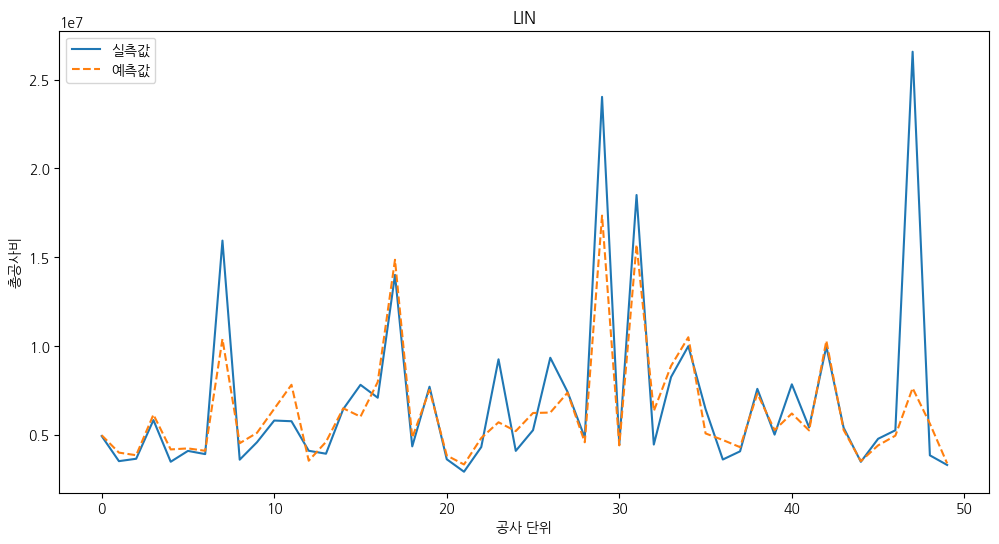

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.059e+15, tolerance: 3.811e+12
  model = cd_fast.enet_coordinate_descent(


Evaluation: LASSO
R2_SCORE: 0.723767, MAPE: 15.174520, MSE: 3645300091824.618164, RMSE: 1909266.899054, MAE: 1023430.844127
`LASSO` object has no attribute `feature_importances_`


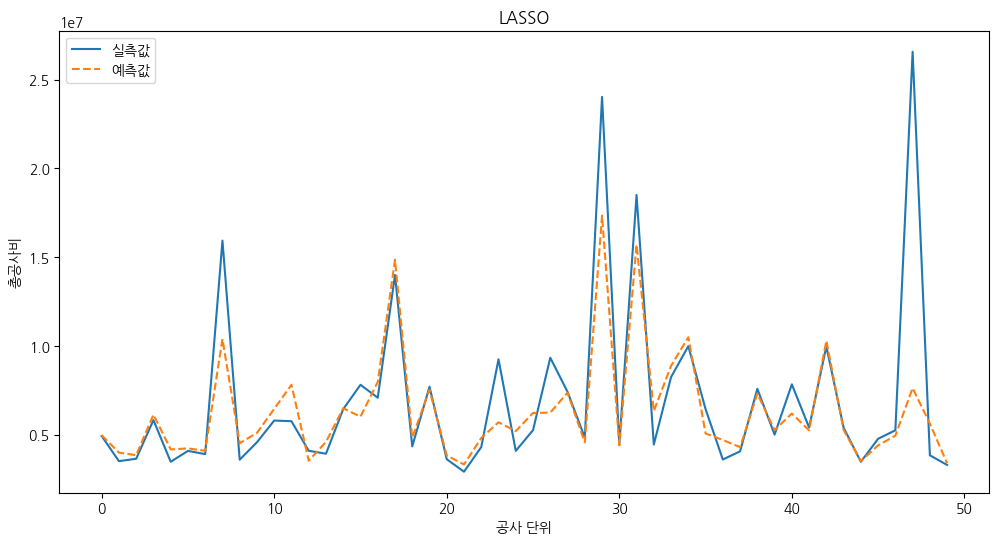

Evaluation: RIDGE
R2_SCORE: 0.724540, MAPE: 15.152039, MSE: 3635091819849.684082, RMSE: 1906591.676225, MAE: 1021784.337109
`RIDGE` object has no attribute `feature_importances_`


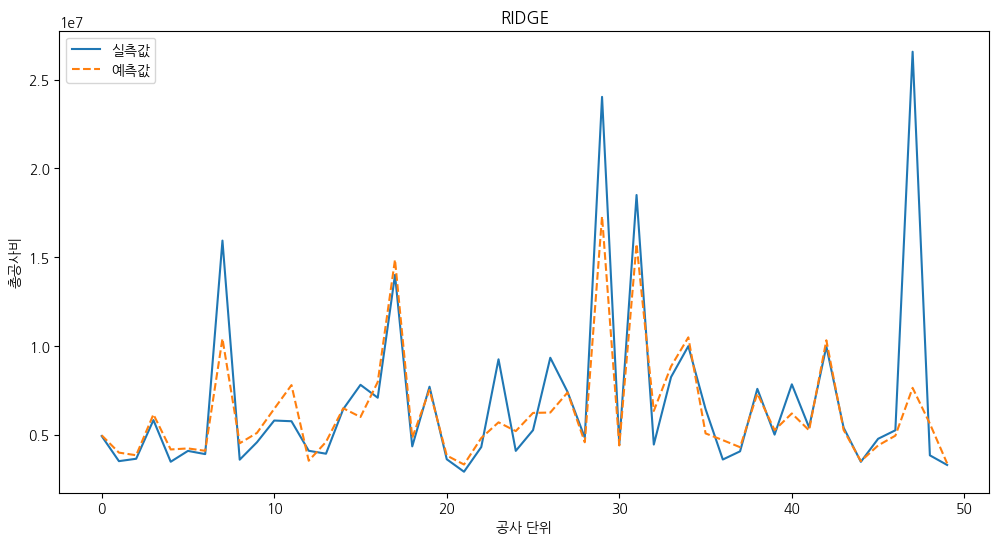

Evaluation: KNR
R2_SCORE: 0.679946, MAPE: 15.303089, MSE: 4223579618839.804199, RMSE: 2055134.939326, MAE: 1085202.641542
`KNR` object has no attribute `feature_importances_`


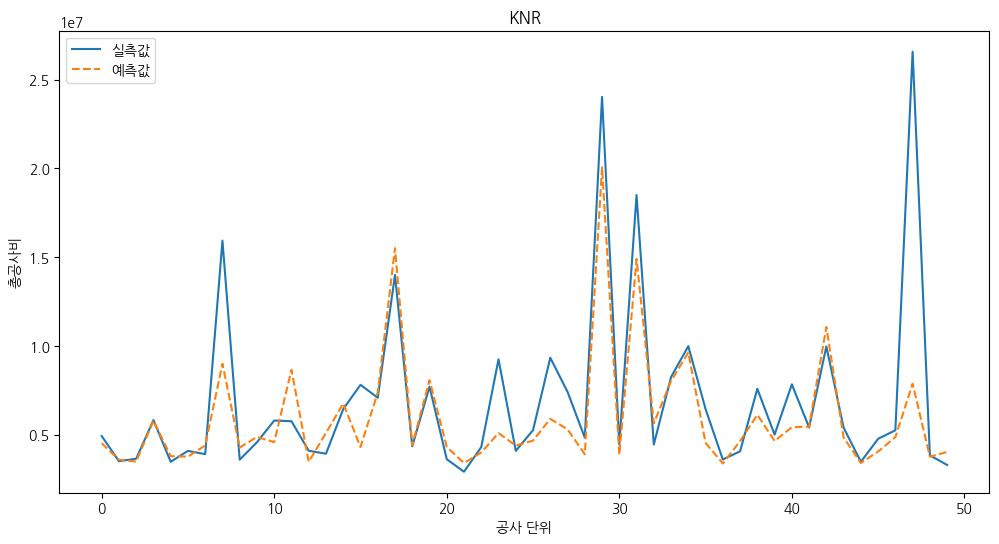

Evaluation: DTR
R2_SCORE: 0.437433, MAPE: 20.689971, MSE: 7423888422669.614258, RMSE: 2724681.343326, MAE: 1352520.549751


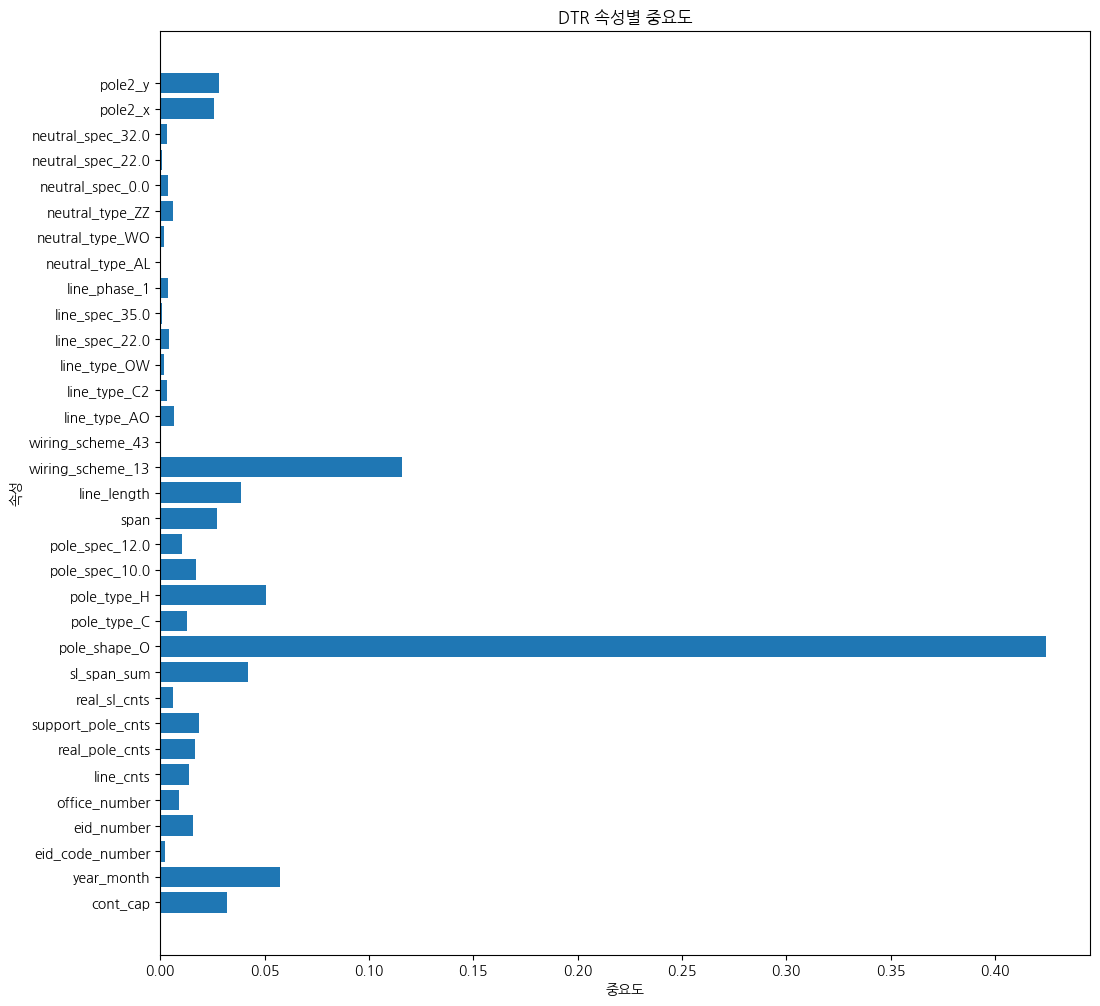

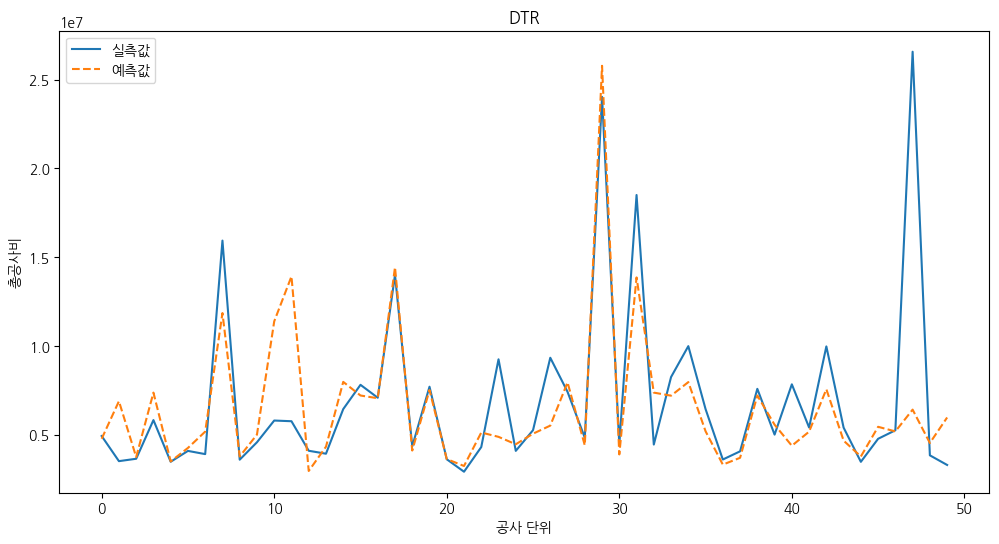

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Evaluation: RFR
R2_SCORE: 0.716535, MAPE: 15.415977, MSE: 3740735979695.267578, RMSE: 1934098.234241, MAE: 1031396.552799


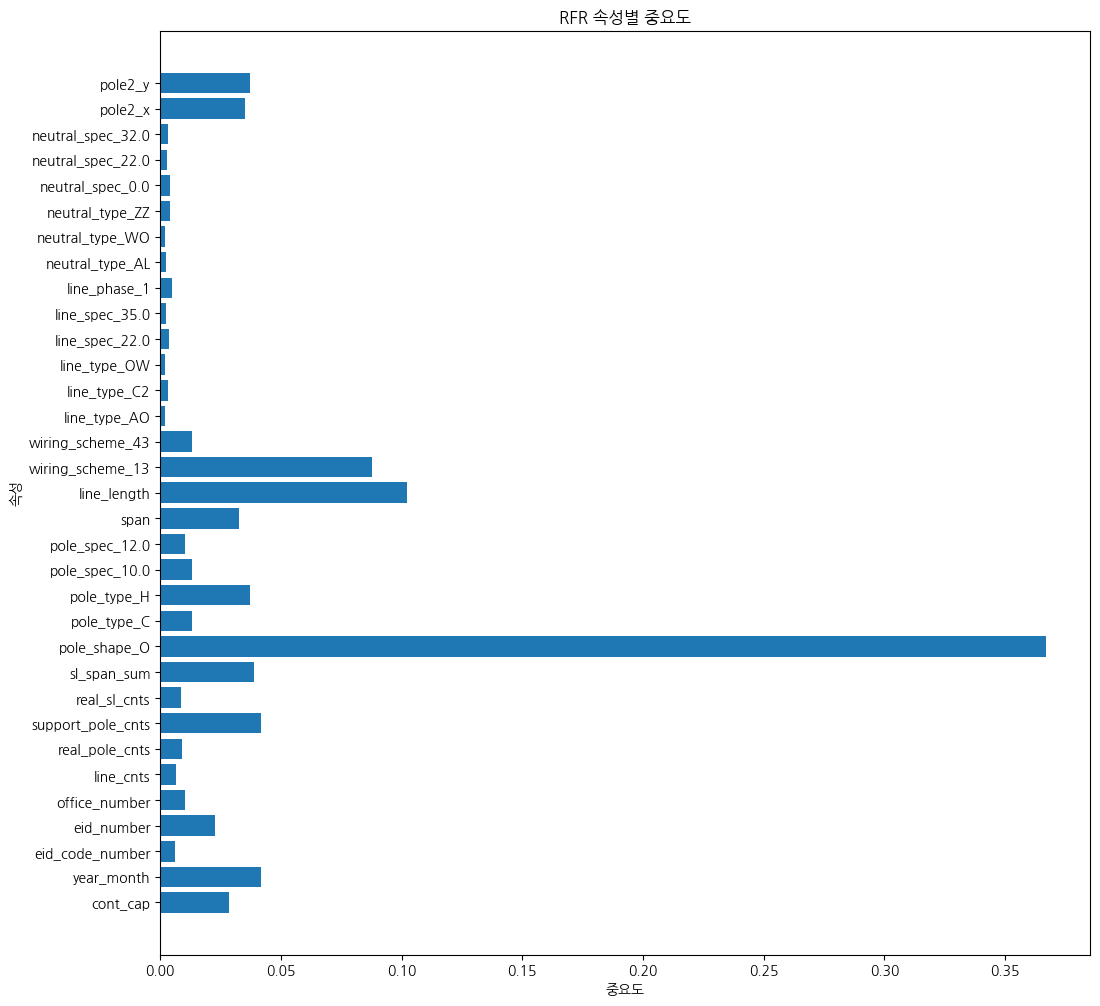

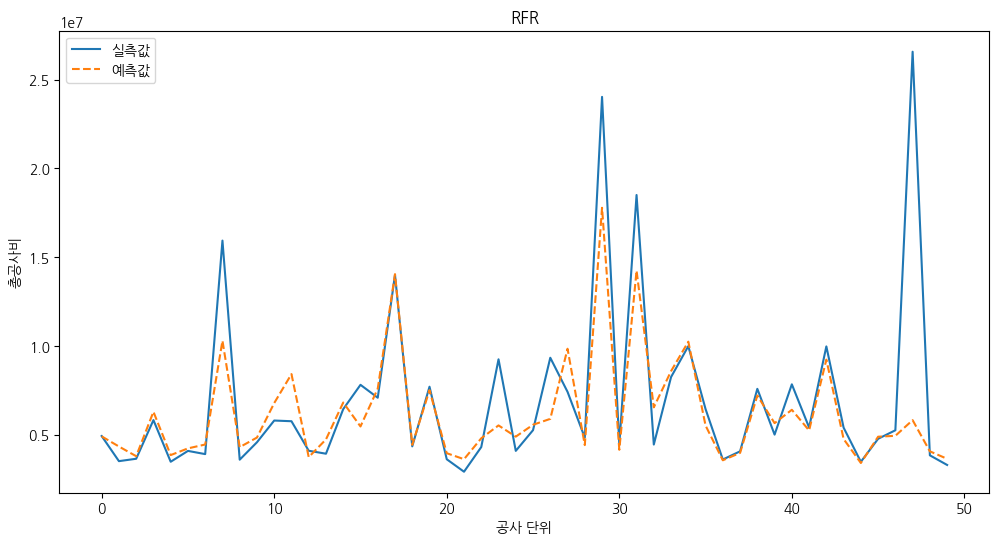

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: GBR
R2_SCORE: 0.729037, MAPE: 14.319702, MSE: 3575748898376.862793, RMSE: 1890965.070639, MAE: 985143.941384


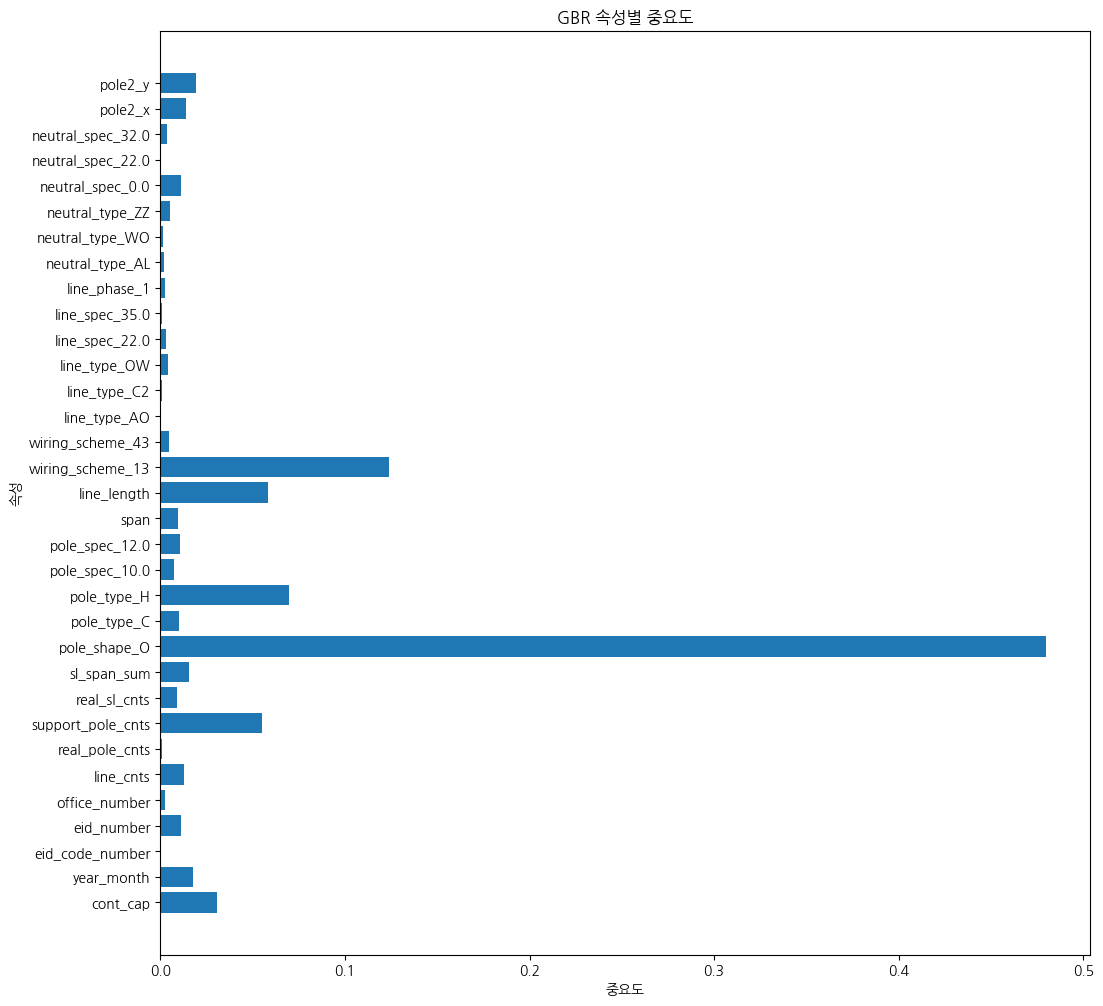

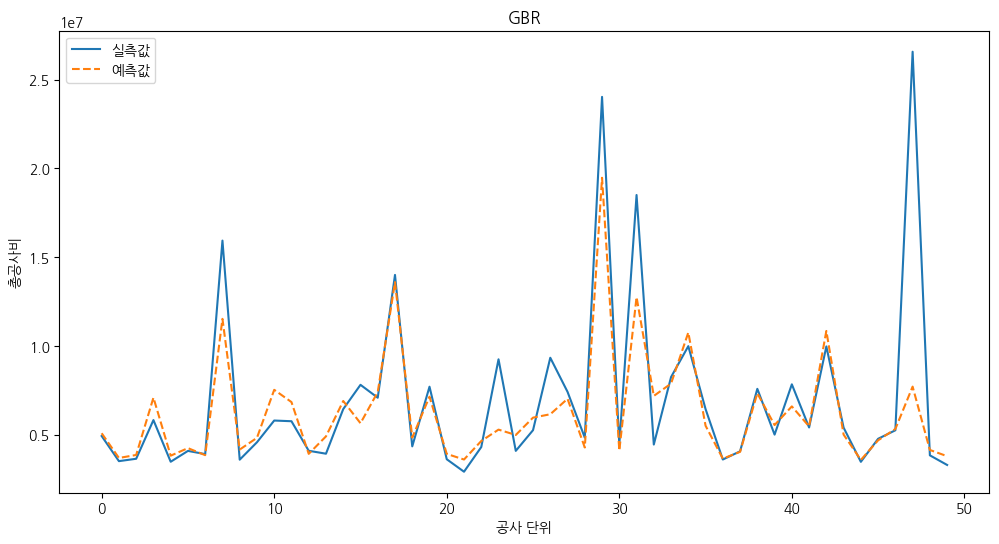

Evaluation: EN
R2_SCORE: 0.722041, MAPE: 15.017899, MSE: 3668070501844.740234, RMSE: 1915220.744939, MAE: 1019206.146387
`EN` object has no attribute `feature_importances_`


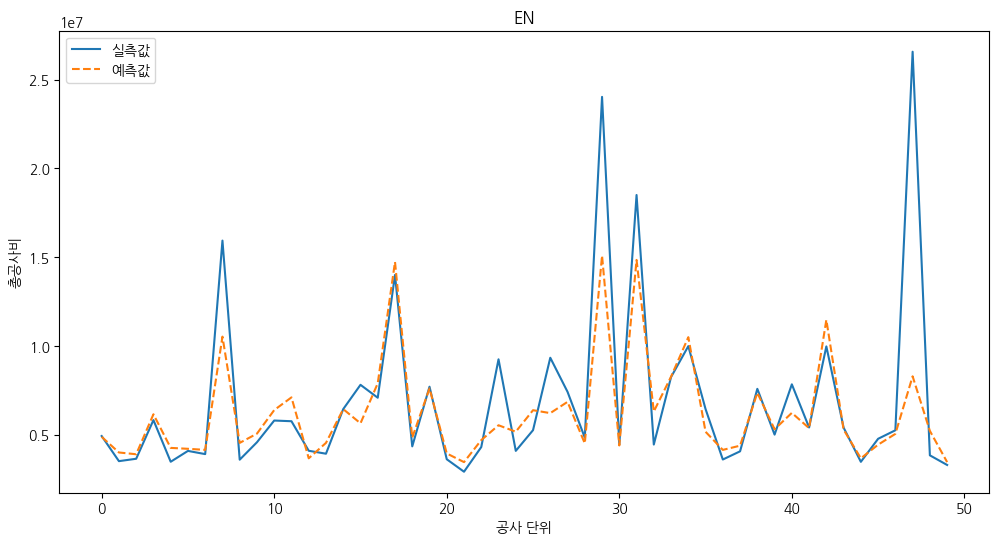

Evaluation: XGR
R2_SCORE: 0.156243, MAPE: 33.982620, MSE: 11134607474341.906250, RMSE: 3336855.926519, MAE: 2345600.825715


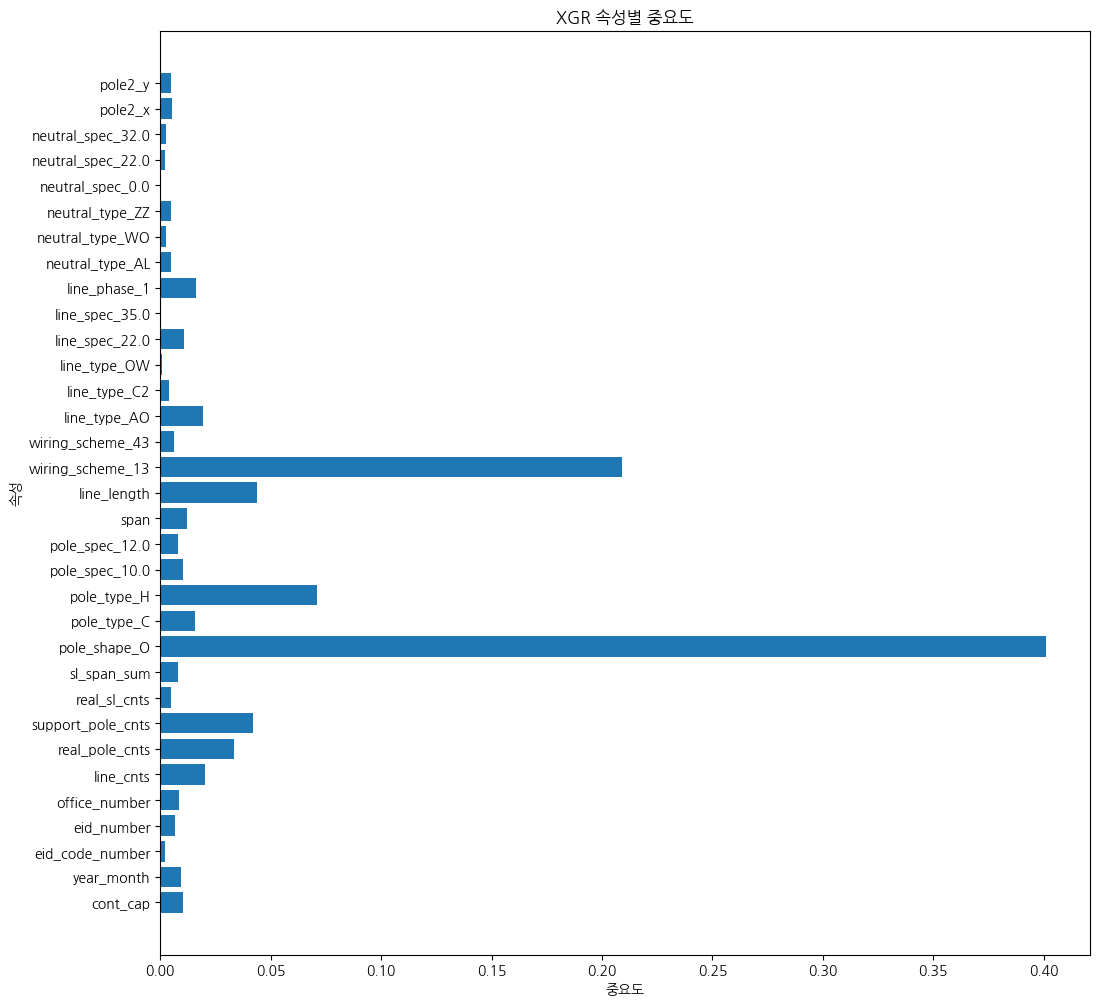

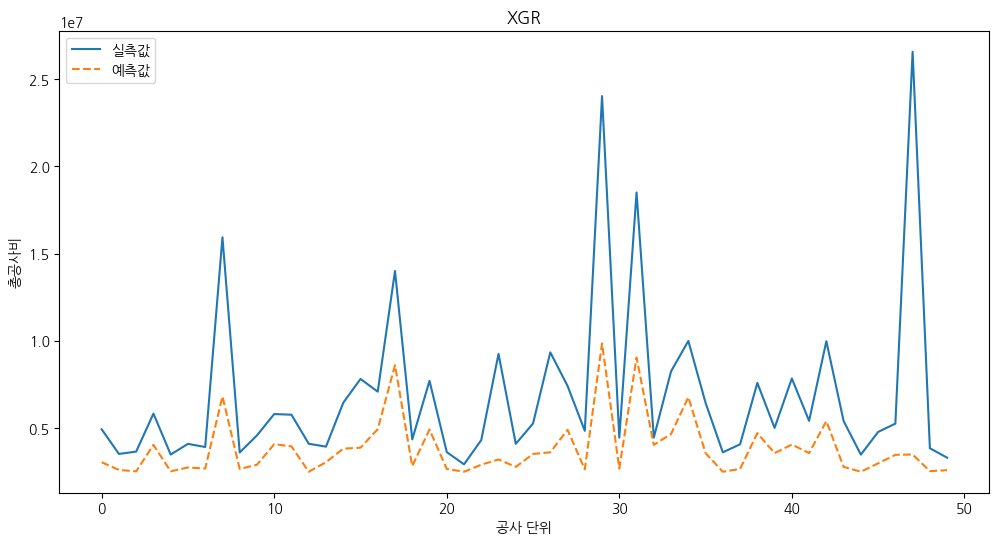

In [7]:
evaluation_values = []
model_names = []
column_names = ['r2score', 'mape', 'mse', 'rmse', 'mae']
for _model_key in ml_models.keys():
    model_fit_and_evaluation(_model_key, display_start=50, display_size=50)
    
df_evaluation = pd.DataFrame(
    evaluation_values, columns=column_names, index=model_names
)

In [8]:
df_evaluation

,r2score,mape,mse,rmse,mae
LIN,0.723752,0.151742,3.645489e+12,1.909316e+06,1.023434e+06
LASSO,0.723767,0.151745,3.645300e+12,1.909267e+06,1.023431e+06
RIDGE,0.724540,0.151520,3.635092e+12,1.906592e+06,1.021784e+06
KNR,0.679946,0.153031,4.223580e+12,2.055135e+06,1.085203e+06
DTR,0.437433,0.206900,7.423888e+12,2.724681e+06,1.352521e+06
RFR,0.716535,0.154160,3.740736e+12,1.934098e+06,1.031397e+06
GBR,0.729037,0.143197,3.575749e+12,1.890965e+06,9.851439e+05
EN,0.722041,0.150179,3.668071e+12,1.915221e+06,1.019206e+06
XGR,0.156243,0.339826,1.113461e+13,3.336856e+06,2.345601e+06
